In [32]:
import json
with open('results.json', 'r') as fp:
    res = json.load(fp)

In [33]:
data = []
for entry in res:
    data += entry['data']['users']

In [34]:
addresses = [entry['id'] for entry in data]
print(len(addresses))

50848


## Notes

You will need to install the `moralis` Python package and to create an API key.
Once your API key is created, create an environment variable for it named `MORALIS_API_KEY`

In [15]:
import asyncio
import os
import aiohttp
from moralis import evm_api
import time
import nest_asyncio
from dotenv import load_dotenv
import pickle
from tqdm import tqdm


load_dotenv()

api_key = os.getenv('MORALIS_API_KEY')

nest_asyncio.apply()


async def get_wallet_active_chains_async(address, timeout=30):
    params = {"address": address}
    try:
        result = await asyncio.wait_for(
            asyncio.to_thread(
                evm_api.wallets.get_wallet_active_chains,
                api_key=api_key,
                params=params
            ),
            timeout=timeout
        )
        return address, result
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=28, rate_limit=28, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    for i in range(0, len(addresses), batch_size):
        batch = addresses[i:i+batch_size]
        start_time = time.time()
        
        tasks = [get_wallet_active_chains_async(address, timeout) for address in batch]
        batch_results = await asyncio.gather(*tasks)
        
        results.extend(batch_results)
        
        pbar.update(len(batch))
        
        with open('walstats_intermediate.pickle', 'wb') as fp:
            pickle.dump(results, fp)
        
        elapsed_time = time.time() - start_time
        if elapsed_time < 1:
            await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

try:
    with open('walstats_intermediate.pickle', 'rb') as fp:
        previous_results = pickle.load(fp)
    processed_addresses = set(result[0] for result in previous_results)
    remaining_addresses = [addr for addr in addresses if addr not in processed_addresses]
    print(f"Resuming from {len(previous_results)} previously processed addresses")
except FileNotFoundError:
    previous_results = []
    remaining_addresses = addresses

new_results = asyncio.get_event_loop().run_until_complete(process_addresses(remaining_addresses))

all_results = previous_results + new_results

with open('walstats_final.pickle', 'wb') as fp:
    pickle.dump(all_results, fp)

print("Processing completed. Results saved in 'walstats_final.pickle'")

Processing addresses:   0%|                                                                | 0/50825 [00:00<?, ?it/s]

Error processing address 0x000000000000000000000000000000000000dead: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:03:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '206', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"ce-Q6cxI6wltKm7g/Me/saPDwpMsfQ"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc1ea84a05d1d6-ICN'})
HTTP response body: b'{"message":"The address 0x000000000000000000000000000000000000dead provided contains a large amount of data. You can email us at hello@moralis.io and explain your use-case and we will see how we can help."}'

Error processing address 0x0000000000000000000000000000000000000000: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:03:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Leng

Processing addresses:   7%|███▎                                               | 3332/50825 [05:12<1:23:44,  9.45it/s]

Error processing address 0x1111111254eeb25477b68fb85ed929f73a960582: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:08:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKgXWZ2aK6g"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc26427f5930d3-ICN'})
HTTP response body: b'{"message":"Wallet address is not supported"}'

Error processing address 0x1111111254fb6c44bac0bed2854e76f90643097d: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:08:38 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKg

Processing addresses:  16%|████████▎                                          | 8316/50825 [12:56<1:09:17, 10.22it/s]

Error processing address 0x2a737d2c4232e127af366a8462110ff8892ace5d: (500)
Reason: Internal Server Error
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:16:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '74', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"4a-Trwd3CpM6Dtz6UyrDapRSOVLBxo"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc31a28f298b5c-ICN'})
HTTP response body: b'{"message":"Unknown error occurred. Please try again or contact support."}'



Processing addresses:  16%|████████▎                                          | 8344/50825 [13:26<4:36:29,  2.56it/s]

Timeout processing address 0x2a5bfd06a5e9d16923ec8e5452ddb924331228c9


Processing addresses:  53%|██████████████████████████▋                       | 27160/50825 [44:21<2:42:55,  2.42it/s]

Timeout processing address 0x88f84293b918e448e7a78bdd17c09eb7913f5fca


Processing addresses:  63%|████████████████████████████████▌                   | 31780/50825 [52:10<32:15,  9.84it/s]

Error processing address 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 04 Sep 2024 07:55:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '45', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '50', 'ETag': 'W/"2d-D087WpUkh2am29tsXKgXWZ2aK6g"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '8bdc6b0dde5da7dd-ICN'})
HTTP response body: b'{"message":"Wallet address is not supported"}'



Processing addresses:  72%|██████████████████████████████████▋             | 36680/50825 [1:01:17<1:34:47,  2.49it/s]

Timeout processing address 0xb8aceb35cf197a082b1774bbe5e3c1e910a34d82


Processing addresses: 100%|██████████████████████████████████████████████████| 50825/50825 [1:26:14<00:00,  9.82it/s]


Processing completed. Results saved in 'walstats_final.pickle'


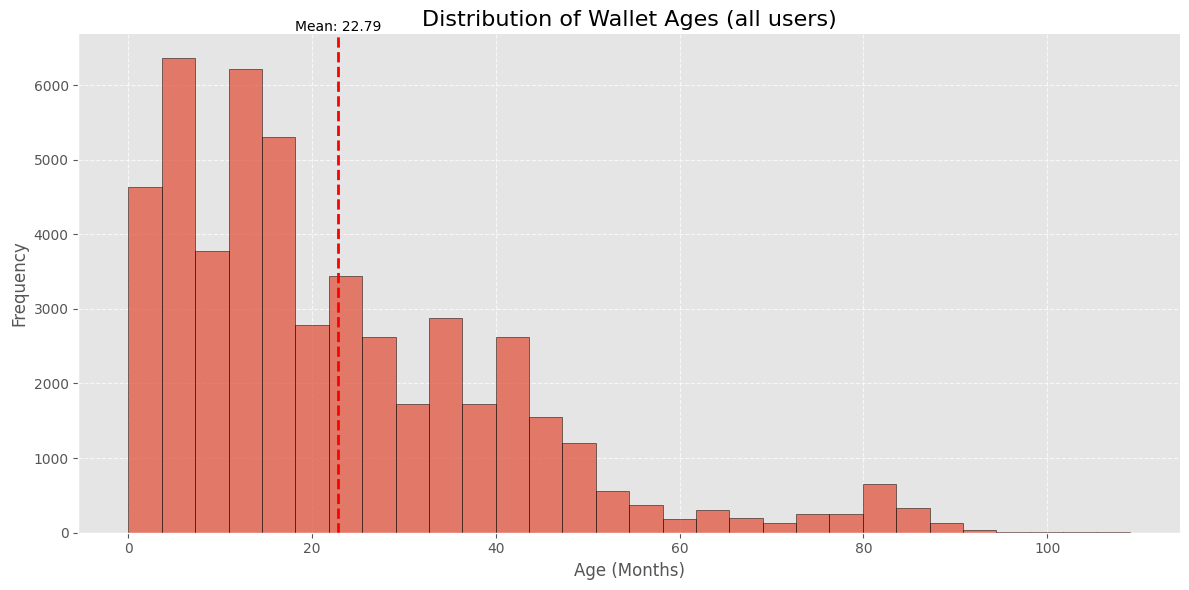

In [35]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np


def calculate_age_months(first_transaction_date):
    current_date = datetime.now()
    first_date = datetime.strptime(first_transaction_date, "%Y-%m-%dT%H:%M:%S.%fZ")
    age_months = (current_date.year - first_date.year) * 12 + (current_date.month - first_date.month)
    return age_months

ages = {}
for user, user_data in all_results:
    if user_data and isinstance(user_data, dict) and 'active_chains' in user_data:
        for chain in user_data['active_chains']:
            if isinstance(chain, dict) and chain.get('chain') == 'eth':
                first_transaction = chain.get('first_transaction')
                if isinstance(first_transaction, dict):
                    first_transaction_date = first_transaction.get('block_timestamp')
                    if first_transaction_date:
                        try:
                            age = calculate_age_months(first_transaction_date)
                            ages[user] = (age)
                        except ValueError:
                            print(f"Invalid date format: {first_transaction_date}")

ages_series = pd.Series(ages)

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(12, 6))
ages_series.hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Ages (all users)', fontsize=16)
ax.set_xlabel('Age (Months)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = ages_series.mean()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()

In [40]:
from utils.gho_filter import filter_gho_users
gho_users = set(filter_gho_users(data))
len(gho_users)

2292

In [46]:
gho_ages_series = ages_series[list((gho_users) & set(ages_series.index))]

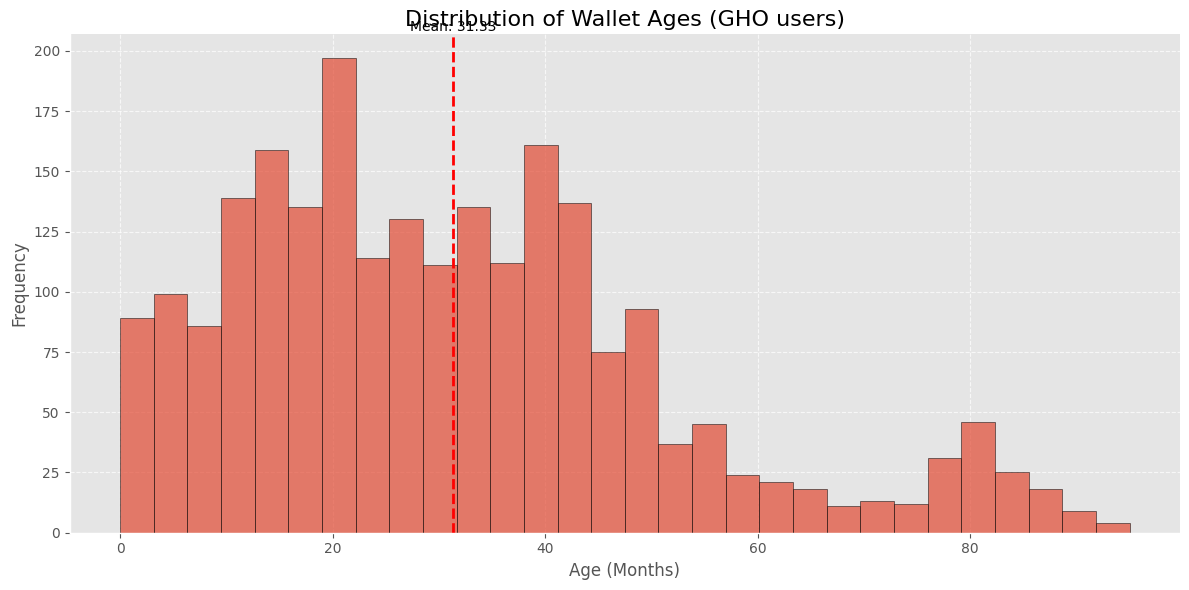

In [47]:

fig, ax = plt.subplots(figsize=(12, 6))
gho_ages_series.hist(ax=ax, bins=30, edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Wallet Ages (GHO users)', fontsize=16)
ax.set_xlabel('Age (Months)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mean_age = gho_ages_series.mean()
ax.axvline(mean_age, color='red', linestyle='dashed', linewidth=2)
ax.text(mean_age, ax.get_ylim()[1], f'Mean: {mean_age:.2f}', 
        horizontalalignment='center', verticalalignment='bottom')

plt.tight_layout()
plt.show()